<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Deep IV: Use Case and Examples

Deep IV uses deep neural networks in a two-stage instrumental variable (IV) estimation of causal effects, as described in [this ICML publication](http://proceedings.mlr.press/v70/hartford17a/hartford17a.pdf) or in the `econml` [specification](https://econml.azurewebsites.net/spec/estimation/iv.html#deep-instrumental-variables).  In the EconML SDK, we have implemented Deep IV estimation on top of the Keras framework for building and training neural networks.  In this notebook, we'll demonstrate how to use the SDK to apply Deep IV to synthetic data.

### Data

Deep IV works in settings where we have several different types of observations:
* Covariates, which we will denote with `X`
* Instruments, which we will denote with `Z`
* Treatments, which we will denote with `T`
* Responses, which we will denote with `Y`

The main requirement is that `Z` is a set of valid instruments; in particular `Z` should affect the responses `Y` only through the treatments `T`.  We assume that `Y` is an arbitrary function of `T` and `X`, plus an additive error term, and that `T` is an arbitrary function of `Z` and `X`.  Deep IV then allows us to estimate `Y` given `T` and `X`.

### Estimation

To do this, the Deep IV estimator uses a two-stage approach that involves solving two subproblems:
1. It estimates the *distribution* of the treatment `T` given `Z` and `X`, using a mixture density network.
2. It estimates the dependence of the response `Y` on `T` and `X`.

Both of these estimates are performed using neural networks.  See the paper for a more complete description of the setup and estimation approach.

### Using the SDK

In the `econml` package, our Deep IV estimator is built on top of the Keras framework; we support either the Tensorflow or the Theano backends.  There are three steps to using the `DeepIVEstimator`:

1. Construct an instance.  
    * The `m` and `h` arguments to the initializer specify deep neural network models for estimating `T` and `Y` as described above.  They are each *functions* that take two Keras inputs and return a Keras model (the inputs are `z` and `x` in the case of `m` and the output's shape should match `t`'s; the inputs are `t` and `x` in the case of `h` and the output's shape should match `y`'s).  Note that the `h` function will be called multiple times, but should reuse the same weights - see below for a concrete example of how to achieve this using the Keras API.
    * The `n_samples`, `use_upper_bound_loss`, and `n_gradient_samples` arguments together determine how the loss for the response model will be computed.
        * If `use_upper_bound_loss` is `False` and `n_gradient_samples` is zero, then `n_samples` samples will be averaged to approximate the response - this will provide an unbiased estimate of the correct loss only in the limit as the number of samples goes to infinity.
        * If `use_upper_bound_loss` is `False` and `n_gradient_samples` is nonzero, then we will average `n_samples` samples to approximate the response a first time and average `n_gradient_samples` samples to approximate it a second time - combining these allows us to provide an unbiased estimate of the true loss.
        * If `use_upper_bound_loss` is `True`, then `n_gradient_samples` must be `0`; `n_samples` samples will be used to get an unbiased estimate of an upper bound of the true loss - this is equivalent to adding a regularization term penalizing the variance of the response model (see the `econml` specification linked above for a derivation of this fact).
2. Call `fit` with training samples of `Y`, `T`, `X`, and `Z`; this will train both sub-models.
3. Call `effect` or `predict` depending on what output you want.  `effect` calculates the difference in outcomes based on the features and two different treatments, while `predict` predicts the outcome based on a single treatment.

The remainder of this notebook will walk through a concete example.

In [1]:
from econml.deepiv import DeepIVEstimator
from econml.bootstrap import BootstrapEstimator
import keras
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


## Synthetic data

To demonstrate the Deep IV approach, we'll construct a syntetic dataset obeying the requirements set out above.  In this case, we'll take `X`, `Z`, `T`, and `Y` to come from the following distribution: 

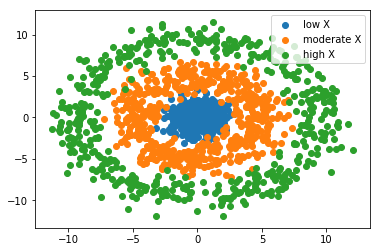

In [2]:
n = 5000

x = np.random.uniform(low=0.0, high=10.0, size=(n,1))
theta = np.random.uniform(low=0.0, high=2 * np.pi, size=(n,1))
z = x * np.cos(theta) + np.random.normal(size=(n,1))
t = x * np.sin(theta) + np.random.normal(size=(n,1))
y = t * t - x * x + np.random.normal(size=(n,1))

plt.scatter(z[x < 1], t[x < 1], label='low X')
plt.scatter(z[(x > 4.5) * (x < 5.5)], t[(x > 4.5) * (x < 5.5)], label='moderate X')
plt.scatter(z[x > 9], t[x > 9], label='high X')
plt.legend()
plt.show()

Here, we'll imagine that `Z` and `X` are causally affecting `T`; as you can see in the plot above, low or high values of `Z` drive moderate values of `T` and moderate values of `Z` cause `T` to have a bi-modal distribution when `X` is high, but a unimodal distribution centered on 0 when `X` is low.  `Y` is a non-linear function of `T` and `X` with no direct dependence on `Z` plus additive noise (as required).  We want to estimate the effect of particular `T` and `X` values on `Y`.

## Defining the neural network models

Now we'll define simple treatment and response models using the Keras `Sequential` model built up of a series of layers.  Each model with have an `input_shape` of 2 (to match the sums of the dimensions of `X` plus `Z` in the treatment case and `T` plus `X` in the response case).

In [3]:
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(2,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])

response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(2,)),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(64, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(32, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(1)])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Now we'll instantiate the `DeepIVEstimator` class using these models.  Defining the response model *outside* of the lambda passed into constructor is important, because (depending on the settings for the loss) it can be used multiple times in the second stage and we want the same weights to be used every time.

In [4]:
deepIvEst = DeepIVEstimator(n_components = 10, # number of gaussians in our mixture density network
                            m = lambda z, x : treatment_model(keras.layers.concatenate([z,x])), # treatment model
                            h = lambda t, x : response_model(keras.layers.concatenate([t,x])),  # response model
                            n_samples = 1, # number of samples to use to estimate the response
                            use_upper_bound_loss = False, # whether to use an approximation to the true loss
                            n_gradient_samples = 1, # number of samples to use in second estimate of the response (to make loss estimate unbiased)
                            optimizer='adam', # Keras optimizer to use for training - see https://keras.io/optimizers/ 
                            s1=100, # number of epochs to train treatment model
                            s2=100) # number of epochs to train response model

## Fitting and predicting using the model
Now we can fit our model to the data:

And now we can create a new set of data and see whether our predicted effect matches the true effect `T*T-X*X`:

In [5]:
boot_est = BootstrapEstimator(deepIvEst, n_bootstrap_samples=3, n_jobs=1)

In [6]:
boot_est.fit(Y=y,T=t,X=x,Z=z)

Instructions for updating:
Use tf.cast instead.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/100
5000/5000 [==============================] - 1s 135us/step - loss: 1.9887
Epoch 2/100
5000/5000 [==============================] - 0s 43us/step - loss: 1.7293
Epoch 3/100
5000/5000 [==============================] - 0s 43us/step - loss: 1.6000
Epoch 4/100
5000/5000 [==============================] - 0s 46us/step - loss: 1.4754
Epoch 5/100
5000/5000 [==============================] - 0s 42us/step - loss: 1.4462
Epoch 6/100
5000/5000 [==============================] - 0s 48us/step - loss: 1.4313
Epoch 7/100
5000/5000 [==============================] - 0s 42us/step - loss: 1.4191
Epoch 8/100
5000/5000 [==============================] - 0s 51us/step - loss: 1.4052
Epoch 9/100
5000/5000 [==============================] - 0s 59us/step - loss: 1.3871
Epoch 10/100
5000/5000 [==============================] - 0s 54us/step - loss: 1.3860
Epoch 11/100
5000/5000 [==============================] - 0s 51us/step - loss: 1.3557
Epoch 12/100
5000/5000 [==============================] - 0s 4

5000/5000 [==============================] - 0s 42us/step - loss: 1.2559
Epoch 97/100
5000/5000 [==============================] - 0s 41us/step - loss: 1.2650
Epoch 98/100
5000/5000 [==============================] - 0s 40us/step - loss: 1.2559
Epoch 99/100
5000/5000 [==============================] - 0s 41us/step - loss: 1.2545
Epoch 100/100
5000/5000 [==============================] - 0s 43us/step - loss: 1.2553
Epoch 1/100
5000/5000 [==============================] - 2s 325us/step - loss: 412.6528
Epoch 2/100
5000/5000 [==============================] - 0s 80us/step - loss: 387.0859
Epoch 3/100
5000/5000 [==============================] - 0s 81us/step - loss: 617.7826
Epoch 4/100
5000/5000 [==============================] - 0s 80us/step - loss: 422.7350
Epoch 5/100
5000/5000 [==============================] - 0s 81us/step - loss: 653.3938
Epoch 6/100
5000/5000 [==============================] - 0s 79us/step - loss: 710.2460
Epoch 7/100
5000/5000 [==============================] - 0s

5000/5000 [==============================] - 0s 78us/step - loss: 167843.4917
Epoch 90/100
5000/5000 [==============================] - 0s 78us/step - loss: 137836.9643
Epoch 91/100
5000/5000 [==============================] - 0s 78us/step - loss: 103741.0485
Epoch 92/100
5000/5000 [==============================] - 0s 78us/step - loss: 79727.9509
Epoch 93/100
5000/5000 [==============================] - 0s 78us/step - loss: 74722.9855
Epoch 94/100
5000/5000 [==============================] - 0s 78us/step - loss: 63387.1779
Epoch 95/100
5000/5000 [==============================] - 0s 78us/step - loss: 64185.0365
Epoch 96/100
5000/5000 [==============================] - 0s 78us/step - loss: 55628.4068
Epoch 97/100
5000/5000 [==============================] - 0s 78us/step - loss: 43819.0124
Epoch 98/100
5000/5000 [==============================] - 0s 80us/step - loss: 47104.4210
Epoch 99/100
5000/5000 [==============================] - 0s 78us/step - loss: 44914.7891
Epoch 100/100
5000/5

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Epoch 1/100
5000/5000 [==============================] - 1s 182us/step - loss: 2.0045
Epoch 2/100
5000/5000 [==============================] - 0s 43us/step - loss: 1.6607
Epoch 3/100
5000/5000 [==============================] - 0s 43us/step - loss: 1.4948
Epoch 4/100
5000/5000 [==============================] - 0s 43us/step - loss: 1.4364
Epoch 5/100
5000/5000 [==============================] - 0s 43us/step - loss: 1.4044
Epoch 6/100
5000/5000 [==============================] - 0s 43us/step - loss: 1.3812
Epoch 7/100
5000/5000 [==============================] - 0s 43us/step - loss: 1.3753
Epoch 8/100
5000/5000 [==============================] - 0s 44us/step - loss: 1.3643
Epoch 9/100
5000/5000 [==============================] - 0s 44us/step - loss: 1.3465
Epoch 10/100
5000/5000 [==============================] - 0s 45us/step - loss: 1.3542
Epoch 11/100
5000/5000 [==============================] - 0s 44us/step - loss: 1.3429
Epoch 12/100
5000/5000 [==============================] - 0s 4

5000/5000 [==============================] - 0s 58us/step - loss: 1.2612
Epoch 97/100
5000/5000 [==============================] - 0s 58us/step - loss: 1.2674
Epoch 98/100
5000/5000 [==============================] - 0s 58us/step - loss: 1.2632
Epoch 99/100
5000/5000 [==============================] - 0s 58us/step - loss: 1.2608
Epoch 100/100
5000/5000 [==============================] - 0s 58us/step - loss: 1.2597
Epoch 1/100
5000/5000 [==============================] - 2s 395us/step - loss: 35390.7064
Epoch 2/100
5000/5000 [==============================] - 0s 91us/step - loss: 37177.5598
Epoch 3/100
5000/5000 [==============================] - 0s 89us/step - loss: 26735.3451
Epoch 4/100
5000/5000 [==============================] - 0s 88us/step - loss: 24856.7782
Epoch 5/100
5000/5000 [==============================] - 0s 88us/step - loss: 24137.4476
Epoch 6/100
5000/5000 [==============================] - 0s 87us/step - loss: 17661.7265
Epoch 7/100
5000/5000 [========================

5000/5000 [==============================] - 0s 88us/step - loss: 1402.6977
Epoch 89/100
5000/5000 [==============================] - 0s 88us/step - loss: 1049.3721
Epoch 90/100
5000/5000 [==============================] - 0s 87us/step - loss: 1306.0729
Epoch 91/100
5000/5000 [==============================] - 0s 86us/step - loss: 798.8228
Epoch 92/100
5000/5000 [==============================] - 0s 85us/step - loss: 1192.0875
Epoch 93/100
5000/5000 [==============================] - 0s 86us/step - loss: 1029.4776
Epoch 94/100
5000/5000 [==============================] - 0s 84us/step - loss: 816.2502
Epoch 95/100
5000/5000 [==============================] - 0s 86us/step - loss: 572.9776
Epoch 96/100
5000/5000 [==============================] - 0s 85us/step - loss: 555.2536
Epoch 97/100
5000/5000 [==============================] - 0s 85us/step - loss: 682.2110
Epoch 98/100
5000/5000 [==============================] - 0s 85us/step - loss: 843.7249
Epoch 99/100
5000/5000 [================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


Epoch 1/100
5000/5000 [==============================] - 1s 244us/step - loss: 1.8028
Epoch 2/100
5000/5000 [==============================] - 0s 46us/step - loss: 1.6410
Epoch 3/100
5000/5000 [==============================] - 0s 46us/step - loss: 1.5660
Epoch 4/100
5000/5000 [==============================] - 0s 45us/step - loss: 1.4292
Epoch 5/100
5000/5000 [==============================] - 0s 45us/step - loss: 1.4113
Epoch 6/100
5000/5000 [==============================] - 0s 45us/step - loss: 1.3772
Epoch 7/100
5000/5000 [==============================] - 0s 46us/step - loss: 1.3717
Epoch 8/100
5000/5000 [==============================] - 0s 45us/step - loss: 1.3592
Epoch 9/100
5000/5000 [==============================] - 0s 45us/step - loss: 1.3341
Epoch 10/100
5000/5000 [==============================] - 0s 45us/step - loss: 1.3403
Epoch 11/100
5000/5000 [==============================] - 0s 45us/step - loss: 1.3287
Epoch 12/100
5000/5000 [==============================] - 0s 4

5000/5000 [==============================] - 0s 46us/step - loss: 1.2648
Epoch 97/100
5000/5000 [==============================] - 0s 47us/step - loss: 1.2611
Epoch 98/100
5000/5000 [==============================] - 0s 47us/step - loss: 1.2610
Epoch 99/100
5000/5000 [==============================] - 0s 46us/step - loss: 1.2628
Epoch 100/100
5000/5000 [==============================] - 0s 47us/step - loss: 1.2676
Epoch 1/100
5000/5000 [==============================] - 2s 411us/step - loss: 560.9157
Epoch 2/100
5000/5000 [==============================] - 0s 84us/step - loss: 903.3724
Epoch 3/100
5000/5000 [==============================] - 0s 81us/step - loss: 955.1131
Epoch 4/100
5000/5000 [==============================] - 0s 81us/step - loss: 2153.7554
Epoch 5/100
5000/5000 [==============================] - 0s 81us/step - loss: 3010.2988
Epoch 6/100
5000/5000 [==============================] - 0s 81us/step - loss: 2315.7496
Epoch 7/100
5000/5000 [==============================] -

5000/5000 [==============================] - 0s 98us/step - loss: 479.0263
Epoch 90/100
5000/5000 [==============================] - 0s 93us/step - loss: 640.5981
Epoch 91/100
5000/5000 [==============================] - 0s 94us/step - loss: 493.3914
Epoch 92/100
5000/5000 [==============================] - 0s 92us/step - loss: 480.5738
Epoch 93/100
5000/5000 [==============================] - 0s 91us/step - loss: 439.2835
Epoch 94/100
5000/5000 [==============================] - 0s 91us/step - loss: 482.0242
Epoch 95/100
5000/5000 [==============================] - 0s 89us/step - loss: 510.6317
Epoch 96/100
5000/5000 [==============================] - 0s 89us/step - loss: 544.5794
Epoch 97/100
5000/5000 [==============================] - 0s 89us/step - loss: 459.0295
Epoch 98/100
5000/5000 [==============================] - 0s 89us/step - loss: 507.6743
Epoch 99/100
5000/5000 [==============================] - 0s 89us/step - loss: 668.2976
Epoch 100/100
5000/5000 [====================

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.5min finished


In [7]:
treatment_effect_interval = boot_est.marginal_effect_interval(X=x, T=t, lower=1, upper=99)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.4s finished


In [8]:
treatment_effect_interval

(array([[[  9.02104473]],
 
        [[  6.85812521]],
 
        [[ -8.48273563]],
 
        ...,
 
        [[ -9.39312077]],
 
        [[ 11.0946331 ]],
 
        [[-11.03507233]]]), array([[[  9.02104473]],
 
        [[  6.85812521]],
 
        [[ -8.48273563]],
 
        ...,
 
        [[ -9.39312077]],
 
        [[ 11.0946331 ]],
 
        [[-11.03507233]]]))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


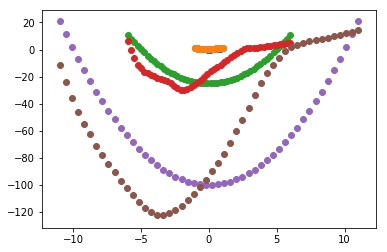

In [9]:
n_test = 500
for x in [0, 5, 10]:
    t = np.linspace(-x-1, x+1)
    y_true = t * t - x * x
    y_pred = boot_est.predict(t, np.full_like(t, x))
    plt.scatter(t, y_true, label='true y, x={0}'.format(x))
    plt.scatter(t, y_pred, label='pred y, x={0}'.format(x))

You can see that despite the fact that the response surface varies with x, our model was able to fit the data reasonably well.